In [5]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Lars
from itertools import combinations
import statsmodels.api as sm

def lars_bayes_rolling_predict(
    df, 
    factors, 
    target, 
    window=60, 
    pred_horizon=3, 
    max_vars=5
):
    df = df.copy()
    preds = []
    dates = []
    for end in range(window, len(df)-pred_horizon):
        start = end - window
        X_win = df.iloc[start:end][factors]
        y_win = df.iloc[start:end][target]
        # LARS变量筛选
        lars = Lars(n_nonzero_coefs=max_vars)
        lars.fit(X_win, y_win)
        idx = np.where(lars.coef_ != 0)[0]
        selected_factors = [factors[i] for i in idx] if len(idx) > 0 else []
        # 备选模型
        models = []
        if len(selected_factors) > 0:
            for k in range(1, min(len(selected_factors), max_vars)+1):
                for comb in combinations(selected_factors, k):
                    X_sub = X_win[list(comb)]
                    X_sub = sm.add_constant(X_sub)
                    model = sm.OLS(y_win, X_sub).fit()
                    if model.rsquared_adj > 0:
                        models.append((comb, model))
        if not models:
            preds.append(np.nan)
            dates.append(df.iloc[end]['date'])
            continue
        bics = np.array([m[1].bic for m in models])
        dBIC = bics - bics.min()
        weights = np.exp(-dBIC/2)
        weights = weights / weights.sum()
        X_pred_subs = []
        for (comb, model) in models:
            X_pred_sub = pd.DataFrame({col: [df.iloc[end][col]] for col in comb})
            X_pred_sub = sm.add_constant(X_pred_sub, has_constant='add')
            missing_cols = set(model.model.exog_names) - set(X_pred_sub.columns)
            for col in missing_cols:
                X_pred_sub[col] = 1 if col == 'const' else 0
            X_pred_sub = X_pred_sub[model.model.exog_names]
            y_hat = model.predict(X_pred_sub).iloc[0]
            X_pred_subs.append(np.sign(y_hat) * abs(y_hat))
        y_bayes = np.dot(weights, X_pred_subs)
        preds.append(y_bayes)
        dates.append(df.iloc[end]['date'])
    pred_df = pd.DataFrame({"date": dates, f"lars_bayes_pred_{pred_horizon}d": preds})
    df = df.merge(pred_df, on="date", how="left")
    return df

def calc_direction_accuracy(df, pred_col, true_col):
    valid = df[[pred_col, true_col]].dropna()
    acc = (np.sign(valid[pred_col]) == np.sign(valid[true_col])).mean()
    return acc

if __name__ == "__main__":
    df = pd.read_csv(r"C:\Users\l\OneDrive\桌面\东方财富\511520  hedging strategy\data\etf_futures_interest_factors.csv", parse_dates=["date"])
    df["spread_change_5d"] = df["spread"].shift(-5) - df["spread"]
      # 选用你构建的因子
    # 选择用于预测价差变化的特征因子。除原有曲线、资金面等因子外，加入利率相对3%名义票息的偏离、
    # 新老券利差、税收利差、IRS swap spread 以及基差因子。
    factors = [
        "factor_10y_gov", "factor_1y_gov", "factor_30y_gov", "factor_5y_gov",
        "factor_30y_5y_slope", "factor_10y_1y_slope", "factor_30y_10y_slope",
        "factor_10y_policy", "factor_policy_spread", "factor_shibor3m",
        "factor_r007", "factor_fr007", "factor_shibor3m_r007_spread",
        "factor_fr007_shibor3m_spread", "factor_curve_curvature",
        # 新增因子：相对票息偏离、新老券利差、税收利差、IRS利差与基差
        "factor_rel_10y_coupon", "factor_rel_30y_coupon",
        "factor_30y_10y_spread", "factor_30y_5y_spread", "factor_10y_5y_spread",
        "factor_tax_spread", "factor_swap_spread", "factor_basis"
    ]
    # 循环调参
    for window in [60, 90, 100, 120]:
        for max_vars in [2, 3, 4, 5]:
            for pred_horizon in [1, 3, 5]:
                df["spread_change_tmp"] = df["spread"].shift(-pred_horizon) - df["spread"]
                df_pred = lars_bayes_rolling_predict(df, factors, "spread_change_tmp", window=window, pred_horizon=pred_horizon, max_vars=max_vars)
                acc = calc_direction_accuracy(df_pred, f"lars_bayes_pred_{pred_horizon}d", "spread_change_tmp")
                print(f"window={window}, max_vars={max_vars}, pred_horizon={pred_horizon}，方向准确率：{acc:.2%}")

window=60, max_vars=2, pred_horizon=1，方向准确率：42.11%
window=60, max_vars=2, pred_horizon=3，方向准确率：48.65%
window=60, max_vars=2, pred_horizon=5，方向准确率：47.22%
window=60, max_vars=3, pred_horizon=1，方向准确率：43.42%
window=60, max_vars=3, pred_horizon=3，方向准确率：51.35%
window=60, max_vars=3, pred_horizon=5，方向准确率：50.00%
window=60, max_vars=4, pred_horizon=1，方向准确率：40.79%
window=60, max_vars=4, pred_horizon=3，方向准确率：58.11%
window=60, max_vars=4, pred_horizon=5，方向准确率：45.83%


e:\Anaconda\envs\py3.9\lib\site-packages\sklearn\linear_model\_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=2.662e-04, with an active set of 4 regressors, and the smallest cholesky pivot element being 1.863e-09. Reduce max_iter or increase eps parameters.
  warnings.warn(
e:\Anaconda\envs\py3.9\lib\site-packages\sklearn\linear_model\_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=4.242e-04, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
e:\Anaconda\envs\py3.9\lib\site-packages\sklearn\linear_model\_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.150e-03, with an active set of 4 regressors, and the smallest cholesky pivot element bein

window=60, max_vars=5, pred_horizon=1，方向准确率：43.42%
window=60, max_vars=5, pred_horizon=3，方向准确率：50.00%


e:\Anaconda\envs\py3.9\lib\site-packages\sklearn\linear_model\_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.114e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  warnings.warn(


window=60, max_vars=5, pred_horizon=5，方向准确率：44.44%
window=90, max_vars=2, pred_horizon=1，方向准确率：34.78%
window=90, max_vars=2, pred_horizon=3，方向准确率：38.64%
window=90, max_vars=2, pred_horizon=5，方向准确率：28.57%
window=90, max_vars=3, pred_horizon=1，方向准确率：43.48%
window=90, max_vars=3, pred_horizon=3，方向准确率：40.91%
window=90, max_vars=3, pred_horizon=5，方向准确率：33.33%
window=90, max_vars=4, pred_horizon=1，方向准确率：47.83%
window=90, max_vars=4, pred_horizon=3，方向准确率：38.64%
window=90, max_vars=4, pred_horizon=5，方向准确率：40.48%
window=90, max_vars=5, pred_horizon=1，方向准确率：45.65%
window=90, max_vars=5, pred_horizon=3，方向准确率：40.91%
window=90, max_vars=5, pred_horizon=5，方向准确率：47.62%
window=100, max_vars=2, pred_horizon=1，方向准确率：33.33%
window=100, max_vars=2, pred_horizon=3，方向准确率：35.29%
window=100, max_vars=2, pred_horizon=5，方向准确率：25.00%
window=100, max_vars=3, pred_horizon=1，方向准确率：36.11%
window=100, max_vars=3, pred_horizon=3，方向准确率：38.24%
window=100, max_vars=3, pred_horizon=5，方向准确率：28.12%
window=100, max_vars=4, p

In [8]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Lars
from itertools import combinations
import statsmodels.api as sm

def lars_bayes_rolling_predict(
    df, 
    factors, 
    target, 
    window=60, 
    pred_horizon=3, 
    max_vars=5
):
    df = df.copy()
    preds = []
    dates = []
    for end in range(window, len(df)-pred_horizon):
        start = end - window
        X_win = df.iloc[start:end][factors]
        y_win = df.iloc[start:end][target]
        # LARS变量筛选
        lars = Lars(n_nonzero_coefs=max_vars)
        lars.fit(X_win, y_win)
        idx = np.where(lars.coef_ != 0)[0]
        selected_factors = [factors[i] for i in idx] if len(idx) > 0 else []
        # 备选模型
        models = []
        if len(selected_factors) > 0:
            for k in range(1, min(len(selected_factors), max_vars)+1):
                for comb in combinations(selected_factors, k):
                    X_sub = X_win[list(comb)]
                    X_sub = sm.add_constant(X_sub)
                    model = sm.OLS(y_win, X_sub).fit()
                    if model.rsquared_adj > 0:
                        models.append((comb, model))
        if not models:
            preds.append(np.nan)
            dates.append(df.iloc[end]['date'])
            continue
        bics = np.array([m[1].bic for m in models])
        dBIC = bics - bics.min()
        weights = np.exp(-dBIC/2)
        weights = weights / weights.sum()
        X_pred_subs = []
        for (comb, model) in models:
            X_pred_sub = pd.DataFrame({col: [df.iloc[end][col]] for col in comb})
            X_pred_sub = sm.add_constant(X_pred_sub, has_constant='add')
            missing_cols = set(model.model.exog_names) - set(X_pred_sub.columns)
            for col in missing_cols:
                X_pred_sub[col] = 1 if col == 'const' else 0
            X_pred_sub = X_pred_sub[model.model.exog_names]
            y_hat = model.predict(X_pred_sub).iloc[0]
            X_pred_subs.append(np.sign(y_hat) * abs(y_hat))
        y_bayes = np.dot(weights, X_pred_subs)
        preds.append(y_bayes)
        dates.append(df.iloc[end]['date'])
    pred_df = pd.DataFrame({"date": dates, f"lars_bayes_pred_{pred_horizon}d": preds})
    df = df.merge(pred_df, on="date", how="left")
    return df

def calc_direction_accuracy(df, pred_col, true_col):
    valid = df[[pred_col, true_col]].dropna()
    acc = (np.sign(valid[pred_col]) == np.sign(valid[true_col])).mean()
    return acc

if __name__ == "__main__":
    df = pd.read_csv(r"C:\Users\l\OneDrive\桌面\东方财富\511520  hedging strategy\data\etf_futures_interest_factors.csv", parse_dates=["date"])
    df["spread_change_5d"] = df["spread"].shift(-5) - df["spread"]
    
    factors = [
        "factor_10y_gov", "factor_1y_gov", "factor_30y_gov", "factor_5y_gov",
        "factor_30y_5y_slope", "factor_10y_1y_slope", "factor_30y_10y_slope",
        "factor_10y_policy", "factor_policy_spread", "factor_shibor3m",
        "factor_r007", "factor_fr007", "factor_shibor3m_r007_spread",
        "factor_fr007_shibor3m_spread", "factor_curve_curvature"
    ]
    
    # 循环调参
    for window in [60, 90, 100, 120]:
        for max_vars in [2, 3, 4, 5]:
            for pred_horizon in [1, 3, 5, 7]:
                df["spread_change_tmp"] = df["spread"].shift(-pred_horizon) - df["spread"]
                df_pred = lars_bayes_rolling_predict(df, factors, "spread_change_tmp", window=window, pred_horizon=pred_horizon, max_vars=max_vars)
                acc = calc_direction_accuracy(df_pred, f"lars_bayes_pred_{pred_horizon}d", "spread_change_tmp")
                print(f"window={window}, max_vars={max_vars}, pred_horizon={pred_horizon}，方向准确率：{acc:.2%}")

window=60, max_vars=2, pred_horizon=1，方向准确率：52.31%
window=60, max_vars=2, pred_horizon=3，方向准确率：49.32%
window=60, max_vars=2, pred_horizon=5，方向准确率：47.22%
window=60, max_vars=2, pred_horizon=7，方向准确率：58.57%
window=60, max_vars=3, pred_horizon=1，方向准确率：55.26%
window=60, max_vars=3, pred_horizon=3，方向准确率：43.84%
window=60, max_vars=3, pred_horizon=5，方向准确率：47.22%
window=60, max_vars=3, pred_horizon=7，方向准确率：62.86%


e:\Anaconda\envs\py3.9\lib\site-packages\sklearn\linear_model\_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.117e-03, with an active set of 3 regressors, and the smallest cholesky pivot element being 5.053e-08. Reduce max_iter or increase eps parameters.
  warnings.warn(


window=60, max_vars=4, pred_horizon=1，方向准确率：52.63%
window=60, max_vars=4, pred_horizon=3，方向准确率：42.47%


e:\Anaconda\envs\py3.9\lib\site-packages\sklearn\linear_model\_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=3.875e-03, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  warnings.warn(


window=60, max_vars=4, pred_horizon=5，方向准确率：45.83%


e:\Anaconda\envs\py3.9\lib\site-packages\sklearn\linear_model\_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=9.331e-03, with an active set of 3 regressors, and the smallest cholesky pivot element being 5.960e-08. Reduce max_iter or increase eps parameters.
  warnings.warn(


window=60, max_vars=4, pred_horizon=7，方向准确率：64.29%


e:\Anaconda\envs\py3.9\lib\site-packages\sklearn\linear_model\_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.117e-03, with an active set of 3 regressors, and the smallest cholesky pivot element being 5.053e-08. Reduce max_iter or increase eps parameters.
  warnings.warn(


window=60, max_vars=5, pred_horizon=1，方向准确率：48.68%


e:\Anaconda\envs\py3.9\lib\site-packages\sklearn\linear_model\_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.897e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  warnings.warn(
e:\Anaconda\envs\py3.9\lib\site-packages\sklearn\linear_model\_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=2.098e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  warnings.warn(


window=60, max_vars=5, pred_horizon=3，方向准确率：42.47%


e:\Anaconda\envs\py3.9\lib\site-packages\sklearn\linear_model\_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=2.958e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 1.825e-08. Reduce max_iter or increase eps parameters.
  warnings.warn(
e:\Anaconda\envs\py3.9\lib\site-packages\sklearn\linear_model\_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=2.922e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 1.825e-08. Reduce max_iter or increase eps parameters.
  warnings.warn(
e:\Anaconda\envs\py3.9\lib\site-packages\sklearn\linear_model\_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=2.949e-03, with an active set of 4 regressors, and the smallest cholesky pivot element bein

window=60, max_vars=5, pred_horizon=5，方向准确率：45.83%


e:\Anaconda\envs\py3.9\lib\site-packages\sklearn\linear_model\_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=2.013e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
e:\Anaconda\envs\py3.9\lib\site-packages\sklearn\linear_model\_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=9.331e-03, with an active set of 3 regressors, and the smallest cholesky pivot element being 5.960e-08. Reduce max_iter or increase eps parameters.
  warnings.warn(
e:\Anaconda\envs\py3.9\lib\site-packages\sklearn\linear_model\_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=8.006e-03, with an active set of 3 regressors, and the smallest cholesky pivot element bein

window=60, max_vars=5, pred_horizon=7，方向准确率：67.14%
window=90, max_vars=2, pred_horizon=1，方向准确率：44.12%
window=90, max_vars=2, pred_horizon=3，方向准确率：50.00%
window=90, max_vars=2, pred_horizon=5，方向准确率：71.43%
window=90, max_vars=2, pred_horizon=7，方向准确率：67.50%
window=90, max_vars=3, pred_horizon=1，方向准确率：45.45%
window=90, max_vars=3, pred_horizon=3，方向准确率：40.91%
window=90, max_vars=3, pred_horizon=5，方向准确率：71.43%
window=90, max_vars=3, pred_horizon=7，方向准确率：60.00%
window=90, max_vars=4, pred_horizon=1，方向准确率：46.67%
window=90, max_vars=4, pred_horizon=3，方向准确率：38.64%


e:\Anaconda\envs\py3.9\lib\site-packages\sklearn\linear_model\_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=2.626e-03, with an active set of 3 regressors, and the smallest cholesky pivot element being 9.424e-08. Reduce max_iter or increase eps parameters.
  warnings.warn(


window=90, max_vars=4, pred_horizon=5，方向准确率：47.62%


e:\Anaconda\envs\py3.9\lib\site-packages\sklearn\linear_model\_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=6.679e-03, with an active set of 3 regressors, and the smallest cholesky pivot element being 5.867e-08. Reduce max_iter or increase eps parameters.
  warnings.warn(
e:\Anaconda\envs\py3.9\lib\site-packages\sklearn\linear_model\_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=5.074e-03, with an active set of 3 regressors, and the smallest cholesky pivot element being 4.215e-08. Reduce max_iter or increase eps parameters.
  warnings.warn(


window=90, max_vars=4, pred_horizon=7，方向准确率：72.50%
window=90, max_vars=5, pred_horizon=1，方向准确率：39.13%


e:\Anaconda\envs\py3.9\lib\site-packages\sklearn\linear_model\_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=2.251e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
e:\Anaconda\envs\py3.9\lib\site-packages\sklearn\linear_model\_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=2.216e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
e:\Anaconda\envs\py3.9\lib\site-packages\sklearn\linear_model\_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=2.806e-03, with an active set of 3 regressors, and the smallest cholesky pivot element bein

window=90, max_vars=5, pred_horizon=3，方向准确率：43.18%


e:\Anaconda\envs\py3.9\lib\site-packages\sklearn\linear_model\_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=2.626e-03, with an active set of 3 regressors, and the smallest cholesky pivot element being 9.424e-08. Reduce max_iter or increase eps parameters.
  warnings.warn(
e:\Anaconda\envs\py3.9\lib\site-packages\sklearn\linear_model\_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=2.419e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 5.960e-08. Reduce max_iter or increase eps parameters.
  warnings.warn(
e:\Anaconda\envs\py3.9\lib\site-packages\sklearn\linear_model\_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=2.302e-03, with an active set of 4 regressors, and the smallest cholesky pivot element bein

window=90, max_vars=5, pred_horizon=5，方向准确率：54.76%


e:\Anaconda\envs\py3.9\lib\site-packages\sklearn\linear_model\_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=5.978e-03, with an active set of 3 regressors, and the smallest cholesky pivot element being 7.300e-08. Reduce max_iter or increase eps parameters.
  warnings.warn(
e:\Anaconda\envs\py3.9\lib\site-packages\sklearn\linear_model\_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=9.120e-03, with an active set of 3 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
  warnings.warn(
e:\Anaconda\envs\py3.9\lib\site-packages\sklearn\linear_model\_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=3.176e-03, with an active set of 3 regressors, and the smallest cholesky pivot element bein

window=90, max_vars=5, pred_horizon=7，方向准确率：75.00%
window=100, max_vars=2, pred_horizon=1，方向准确率：57.14%
window=100, max_vars=2, pred_horizon=3，方向准确率：67.65%
window=100, max_vars=2, pred_horizon=5，方向准确率：68.75%
window=100, max_vars=2, pred_horizon=7，方向准确率：55.17%
window=100, max_vars=3, pred_horizon=1，方向准确率：55.56%
window=100, max_vars=3, pred_horizon=3，方向准确率：52.94%
window=100, max_vars=3, pred_horizon=5，方向准确率：68.75%
window=100, max_vars=3, pred_horizon=7，方向准确率：70.00%
window=100, max_vars=4, pred_horizon=1，方向准确率：55.56%
window=100, max_vars=4, pred_horizon=3，方向准确率：50.00%
window=100, max_vars=4, pred_horizon=5，方向准确率：81.25%


e:\Anaconda\envs\py3.9\lib\site-packages\sklearn\linear_model\_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=5.694e-03, with an active set of 3 regressors, and the smallest cholesky pivot element being 9.541e-08. Reduce max_iter or increase eps parameters.
  warnings.warn(


window=100, max_vars=4, pred_horizon=7，方向准确率：60.00%
window=100, max_vars=5, pred_horizon=1，方向准确率：55.56%


e:\Anaconda\envs\py3.9\lib\site-packages\sklearn\linear_model\_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.360e-03, with an active set of 3 regressors, and the smallest cholesky pivot element being 5.771e-08. Reduce max_iter or increase eps parameters.
  warnings.warn(


window=100, max_vars=5, pred_horizon=3，方向准确率：50.00%


e:\Anaconda\envs\py3.9\lib\site-packages\sklearn\linear_model\_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=2.909e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 9.424e-08. Reduce max_iter or increase eps parameters.
  warnings.warn(
e:\Anaconda\envs\py3.9\lib\site-packages\sklearn\linear_model\_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=3.040e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 5.960e-08. Reduce max_iter or increase eps parameters.
  warnings.warn(
e:\Anaconda\envs\py3.9\lib\site-packages\sklearn\linear_model\_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=2.751e-03, with an active set of 3 regressors, and the smallest cholesky pivot element bein

window=100, max_vars=5, pred_horizon=5，方向准确率：71.88%


e:\Anaconda\envs\py3.9\lib\site-packages\sklearn\linear_model\_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=5.185e-03, with an active set of 3 regressors, and the smallest cholesky pivot element being 9.424e-08. Reduce max_iter or increase eps parameters.
  warnings.warn(
e:\Anaconda\envs\py3.9\lib\site-packages\sklearn\linear_model\_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=5.694e-03, with an active set of 3 regressors, and the smallest cholesky pivot element being 9.541e-08. Reduce max_iter or increase eps parameters.
  warnings.warn(


window=100, max_vars=5, pred_horizon=7，方向准确率：66.67%
window=120, max_vars=2, pred_horizon=1，方向准确率：73.33%
window=120, max_vars=2, pred_horizon=3，方向准确率：71.43%
window=120, max_vars=2, pred_horizon=5，方向准确率：91.67%
window=120, max_vars=2, pred_horizon=7，方向准确率：100.00%
window=120, max_vars=3, pred_horizon=1，方向准确率：81.25%
window=120, max_vars=3, pred_horizon=3，方向准确率：71.43%
window=120, max_vars=3, pred_horizon=5，方向准确率：91.67%
window=120, max_vars=3, pred_horizon=7，方向准确率：90.00%
window=120, max_vars=4, pred_horizon=1，方向准确率：81.25%
window=120, max_vars=4, pred_horizon=3，方向准确率：78.57%
window=120, max_vars=4, pred_horizon=5，方向准确率：91.67%
window=120, max_vars=4, pred_horizon=7，方向准确率：100.00%
window=120, max_vars=5, pred_horizon=1，方向准确率：75.00%
window=120, max_vars=5, pred_horizon=3，方向准确率：71.43%
window=120, max_vars=5, pred_horizon=5，方向准确率：91.67%
window=120, max_vars=5, pred_horizon=7，方向准确率：100.00%


In [7]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Lars
from itertools import combinations
import statsmodels.api as sm

def lars_bayes_rolling_predict(
    df, 
    factors, 
    target, 
    window=100, 
    pred_horizon=5, 
    max_vars=4
):
    df = df.copy()
    preds = []
    dates = []
    for end in range(window, len(df)-pred_horizon):
        start = end - window
        X_win = df.iloc[start:end][factors]
        y_win = df.iloc[start:end][target]
        # LARS变量筛选
        lars = Lars(n_nonzero_coefs=max_vars)
        lars.fit(X_win, y_win)
        idx = np.where(lars.coef_ != 0)[0]
        selected_factors = [factors[i] for i in idx] if len(idx) > 0 else []
        # 备选模型
        models = []
        if len(selected_factors) > 0:
            for k in range(1, min(len(selected_factors), max_vars)+1):
                for comb in combinations(selected_factors, k):
                    X_sub = X_win[list(comb)]
                    X_sub = sm.add_constant(X_sub)
                    model = sm.OLS(y_win, X_sub).fit()
                    if model.rsquared_adj > 0:
                        models.append((comb, model))
        if not models:
            preds.append(np.nan)
            dates.append(df.iloc[end]['date'])
            continue
        bics = np.array([m[1].bic for m in models])
        dBIC = bics - bics.min()
        weights = np.exp(-dBIC/2)
        weights = weights / weights.sum()
        X_pred_subs = []
        for (comb, model) in models:
            X_pred_sub = pd.DataFrame({col: [df.iloc[end][col]] for col in comb})
            X_pred_sub = sm.add_constant(X_pred_sub, has_constant='add')
            missing_cols = set(model.model.exog_names) - set(X_pred_sub.columns)
            for col in missing_cols:
                X_pred_sub[col] = 1 if col == 'const' else 0
            X_pred_sub = X_pred_sub[model.model.exog_names]
            y_hat = model.predict(X_pred_sub).iloc[0]
            X_pred_subs.append(np.sign(y_hat) * abs(y_hat))
        y_bayes = np.dot(weights, X_pred_subs)
        preds.append(y_bayes)
        dates.append(df.iloc[end]['date'])
    pred_df = pd.DataFrame({"date": dates, f"lars_bayes_pred_{pred_horizon}d": preds})
    df = df.merge(pred_df, on="date", how="left")
    return df

def calc_direction_accuracy(df, pred_col, true_col):
    valid = df[[pred_col, true_col]].dropna()
    acc = (np.sign(valid[pred_col]) == np.sign(valid[true_col])).mean()
    return acc

if __name__ == "__main__":
    df = pd.read_csv(r"C:\Users\l\OneDrive\桌面\东方财富\511520  hedging strategy\data\etf_futures_interest_factors.csv", parse_dates=["date"])
    df["spread_change_5d"] = df["spread"].shift(-5) - df["spread"]
     
    factors = [
        "factor_10y_gov", "factor_1y_gov", "factor_30y_gov", "factor_5y_gov",
        "factor_30y_5y_slope", "factor_10y_1y_slope", "factor_30y_10y_slope",
        "factor_10y_policy", "factor_policy_spread", "factor_shibor3m",
        "factor_r007", "factor_fr007", "factor_shibor3m_r007_spread",
        "factor_fr007_shibor3m_spread", "factor_curve_curvature"
    ]
    # 滚动LARS+BIC贝叶斯预测
    df = lars_bayes_rolling_predict(df, factors, "spread_change_5d", window=100, pred_horizon=5, max_vars=4)
    # 保存结果
    df.to_csv(r"C:\Users\l\OneDrive\桌面\东方财富\511520  hedging strategy\prediction\spread_lars_bayes_pred_win100_5d.csv", index=False, encoding="utf-8-sig")
    # 方向预测准确率
    acc = calc_direction_accuracy(df, "lars_bayes_pred_5d", "spread_change_5d")
    print(f"未来5日价差变化方向预测准确率：{acc:.2%}")

未来5日价差变化方向预测准确率：81.25%


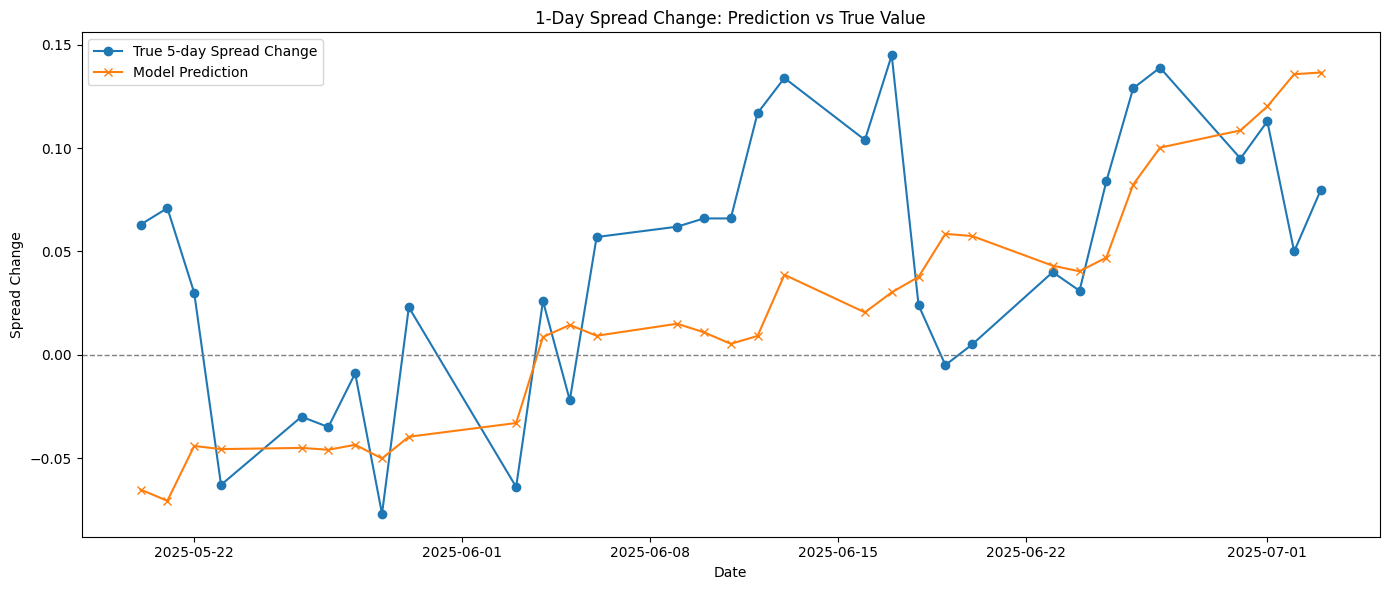

In [3]:
import matplotlib.pyplot as plt

# Only keep rows with prediction results
plot_df = df.dropna(subset=["lars_bayes_pred_5d", "spread_change_5d"]).copy()

plt.figure(figsize=(14, 6))
plt.plot(plot_df["date"], plot_df["spread_change_5d"], label="True 5-day Spread Change", marker='o')
plt.plot(plot_df["date"], plot_df["lars_bayes_pred_5d"], label="Model Prediction", marker='x')
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.title("1-Day Spread Change: Prediction vs True Value")
plt.xlabel("Date")
plt.ylabel("Spread Change")
plt.legend()
plt.tight_layout()
plt.show()

In [4]:
import pandas as pd

df = pd.read_csv(r"C:\Users\l\OneDrive\桌面\东方财富\511520  hedging strategy\data\etf_futures_interest_factors.csv", parse_dates=["date"])

print(df.head())

        date  open_etf  close_etf  high_etf  low_etf  volume_etf    turnover  \
0 2024-12-16   114.341    114.655   114.699  114.341      705557  8087335057   
1 2024-12-17   114.530    114.448   114.530  114.305      790942  9048397555   
2 2024-12-18   114.541    114.243   114.689  113.913      356201  4072494788   
3 2024-12-19   114.370    114.251   114.424  114.190      615158  7031301589   
4 2024-12-20   114.550    114.678   114.686  114.516      656408  7521561774   

   amplitude  pct_change    chg  ...  factor_fr007  \
0       0.31        0.40  0.459  ...        1.4736   
1       0.20       -0.18 -0.207  ...        1.5053   
2       0.68       -0.18 -0.205  ...        1.4879   
3       0.20        0.01  0.008  ...        1.4862   
4       0.15        0.37  0.427  ...        1.4428   

   factor_shibor3m_r007_spread  factor_fr007_shibor3m_spread  \
0                      -0.2270                       -0.2514   
1                      -0.3789                       -0.2127   
2 